# GreatApeT2T-G4s `notebook#3a`
This jupyter notebook contains code snippets to generate:
 1. Models for GC enrichment vs GC content 
 2. Plots for enrichment of pG4s in different functional categories
 3. Plots for methylation and their significance in different functional categories  

all in **Human**

*This notebook requires the outputs generated by `../src/functionalCategoriesHuman.py`*

In [1]:
from itertools import combinations
from matplotlib import patches
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pybedtools import BedTool
from scipy.stats import percentileofscore
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats import proportion
import subprocess
import warnings

from pandas.errors import SettingWithCopyWarning
warnings.simplefilter("ignore", category=SettingWithCopyWarning)
warnings.simplefilter("ignore", category=FutureWarning)

## 1. Models for GC enrichment vs GC content 

In [2]:
''' Fit the quadratic models, for different windows sizes'''

windowSizes = [10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000] #in kb

quad_models = dict()

for windowSize in windowSizes:
    # Load the data
    enrichvsgcGenome = pd.read_csv(f"../datasets/dataForAnalysis/corrG4EnrichvsGC/Homo_sapiens/all_g4sEnrichmentvsGCcontent.{windowSize}kb_Wind.Homo_sapiens.dat.gz", header=None, sep="\t",compression='gzip')
    enrichvsgcGenome.columns = ["G4enrichment", "GCcontent"]

    # Filter the data where G4enrichment > 0
    enrichvsgcGenome = enrichvsgcGenome[enrichvsgcGenome["G4enrichment"] > 0]

    # Create the quadratic term (GCcontent^2)
    enrichvsgcGenome["GCcontent_squared"] = enrichvsgcGenome["GCcontent"] ** 2

    # Define the independent variables (constant, GCcontent, and GCcontent_squared)
    X = sm.add_constant(enrichvsgcGenome[["GCcontent", "GCcontent_squared"]])
    
    # Fit the quadratic model
    quad_models[windowSize] = sm.OLS(enrichvsgcGenome["G4enrichment"], X).fit()

In [3]:
winSize = 5000 #5Mb window size

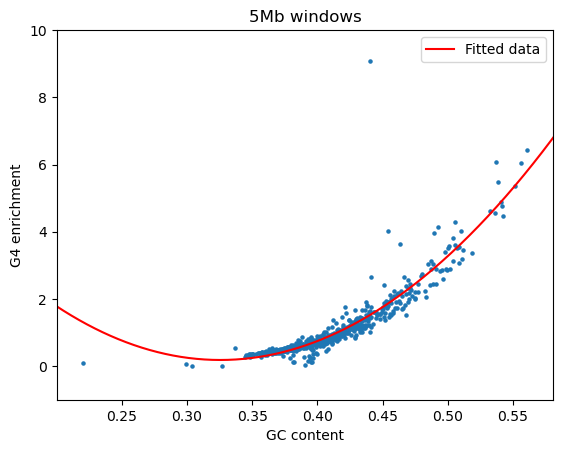

In [4]:
''' To plot the G4 enrichment vs the GC content, and the fitted curve '''

for windowSize in [winSize]:
    enrichvsgcGenome = pd.read_csv(f"../../mapG4ToAlignments2way/functionalAnalysis/human/getResiduals/all_g4sEnrichmentvsGCcontent.{windowSize}kb_Wind.Homo_sapiens.dat", header=None, sep="\t")
    enrichvsgcGenome.columns = ["G4enrichment", "GCcontent"]
    enrichvsgcGenome = enrichvsgcGenome[enrichvsgcGenome["G4enrichment"] > 0]

    plt.scatter(enrichvsgcGenome["GCcontent"], enrichvsgcGenome["G4enrichment"], s=5)
    a,b,c = quad_models[windowSize].params

    x = np.linspace(0,1,1000)
    equation = a+b*x+c*x**2

    plt.plot(x, equation, color="red", label="Fitted data")
    plt.title(f'{int(windowSize/1000)}Mb windows')
    plt.xlim([np.min(enrichvsgcGenome["GCcontent"])-0.02, np.max(enrichvsgcGenome["GCcontent"])+0.02])
    plt.xlabel('GC content')
    plt.ylabel('G4 enrichment')
    plt.ylim([-1,10])
    plt.legend()
    plt.show()

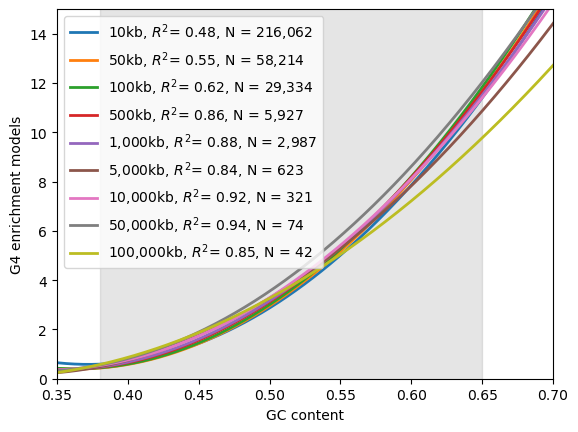

In [5]:
''' To look at the different models together, over the region of interest'''

for i in windowSizes:
    a,b,c = quad_models[i].params

    x = np.linspace(0,1,1000)
    equation = a+b*x+c*x**2

    plt.plot(x, equation, label=f'{i:,}kb, 'r'$R^2$' f'= {round(quad_models[i].rsquared,2)}, N = {int(quad_models[i].nobs):,}', linewidth=2)

plt.gca().add_patch(patches.Rectangle((0.38,-1),0.27, 19, color='grey', alpha=0.2))
plt.xlim([0.35,0.7])
plt.legend()
plt.xlabel('GC content')
plt.ylabel('G4 enrichment models')
plt.ylim([0,15])
plt.show()

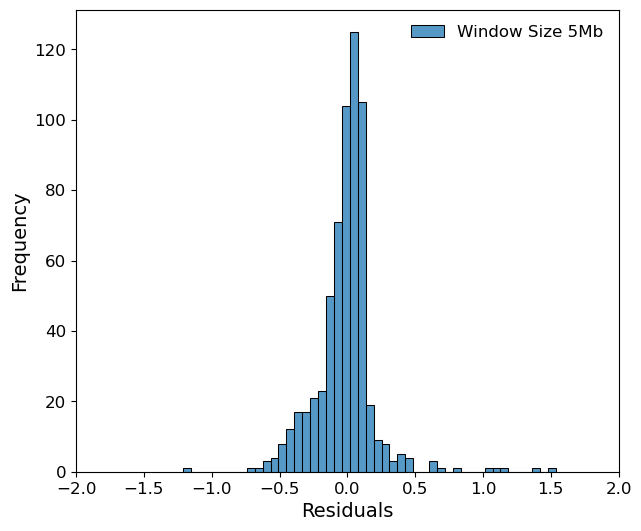

In [6]:
''' To plot the residuals for the 5Mb window size '''

# Get the residuals from the model
residuals = quad_models[5000].resid

# Set a cut-off threshold for filtering residuals
cut = 2
# Correct the logical condition to filter residuals based on the cutoff
residuals = residuals[(residuals < cut) & (residuals > -cut)]

plt.figure(figsize=(7, 6))
sns.histplot(residuals, bins=47, label=f'Window Size {int(windowSize/1000)}Mb', kde=False)

plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim([-cut, cut])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(frameon=False, fontsize=12)
plt.show()

## #. Calculate the GC content of different functional categories.

In [7]:
elements = ["gene", "rna", "exon", "intron", "utr5", "utr3", "cds", "npcgene", "promoter", "enhancer", "cpgi", "or", "repeats", "ngnr"]

# Decompress and index the FASTA file
subprocess.run(f"gzcat ../datasets/dataForAnalysis/genomes/Homo_sapiens/T2T.chm13v2.0.chr.fasta.bgz > temp.file.doNotRemove.fa", shell=True)
subprocess.run(f"samtools faidx temp.file.doNotRemove.fa", shell=True)

# Iterate over the elements
for elem in elements:
    # Construct the appropriate bed file and command based on the element
    if elem != 'cpgi' and elem != 'or':
        command = [
            "gzcat", f"../datasets/functionalOutputs/Homo_sapiens/{elem}_regions.bed.gz", "|",
            "bedtools", "nuc", "-fi", "temp.file.doNotRemove.fa", "-bed", "-", "|",
            "cut", "-f", "10,11,15", "|",
            "awk", "'{sum+=$1+$2; len+=$3} END {print sum/len}'"
        ]
    elif elem == 'cpgi':
        command = [
            "gzcat", "../datasets/dataForAnalysis/geneAnnotations/Homo_sapiens/cpgislands/chrG_cpgislands.bed.gz", "|",
            "bedtools", "nuc", "-fi", "temp.file.doNotRemove.fa", "-bed", "-", "|",
            "cut", "-f", "10,11,15", "|",
            "awk", "'{sum+=$1+$2; len+=$3} END {print sum/len}'"
        ]
    elif elem == 'or':
        command = [
            "gzcat", "../datasets/dataForAnalysis/geneAnnotations/Homo_sapiens/originsofReplication/core_stochastic_origins_chm13v2.0_hglft.ucsc.bed.gz", "|",
            "bedtools", "nuc", "-fi", "temp.file.doNotRemove.fa", "-bed", "-", "|",
            "cut", "-f", "8,9,13", "|",
            "awk", "'{sum+=$1+$2; len+=$3} END {print sum/len}'"
        ]
    
    # Run the command and capture the output
    try:
        output = subprocess.check_output(" ".join(command), shell=True, text=True)
        gcContent = float(output.strip())  # Make sure the output is correctly parsed into a float
    except subprocess.CalledProcessError as e:
        print(f"Error while processing {elem}: {e}")
        gcContent = None  # Handle errors by assigning a None value for this element

    # Print the result
    if gcContent is not None:
        print(f"{elem.upper()}: {np.round(gcContent, 3)}")
    else:
        print(f"{elem.upper()}: Error occurred")

# Cleanup
os.remove("temp.file.doNotRemove.fa")
os.remove("temp.file.doNotRemove.fa.fai")

GENE: 0.419
RNA: 0.419
EXON: 0.482
INTRON: 0.415
UTR5: 0.558
UTR3: 0.423
CDS: 0.525
NPCGENE: 0.401
PROMOTER: 0.522
ENHANCER: 0.516
CPGI: 0.651
OR: 0.5
REPEATS: 0.416
NGNR: 0.383


## 2. Plots for enrichment of pG4s in different functional categories

#### Naming and coloring schema

In [8]:
columnNamesReplaceFold = {"humanSpecificFold": "Human-specific pG4s",
                      "hominidFold": "Great ape pG4s",
                      "homininaeFold": "Homininae pG4s",
                      "homininiFold": "Hominini pG4s",
                      "paniniFold": "Panini pG4s",
                      "ponginiFold": "Pongini pG4s",}

columnNamesReplaceFoldAdj = {"humanSpecificFoldAdj": "Human-specific pG4s",
                      "hominidFoldAdj": "Great ape pG4s",
                      "homininaeFoldAdj": "Homininae pG4s",
                      "homininiFoldAdj": "Hominini pG4s",
                      "paniniFoldAdj": "Panini pG4s",
                      "ponginiFoldAdj": "Pongini pG4s",}

colormapper = {"Human-specific pG4s": "#ffa600",
               "Great ape pG4s": "#004d71",
               "Homininae pG4s": "#8759a1",
               "Hominini pG4s": "#f75a78",
               "Panini pG4s": "#aaa",
               "Pongini pG4s": "#aaa",}

colormapper2 = {"humanSpecific": "#ffa600",
                "hominid": "#004d71",
                "homininae": "#8759a1",
                "hominini": "#f75a78",
                "panini": "#aaa",
                "pongini": "#aaa",}

In [9]:
rcParams['font.family'] = 'Arial'

#### Define necessary functions

In [10]:
def calculate_significance(residuals, region_residual):
    """
    Calculate the significance of the residual in the specific region
    using its percentile rank in the overall genome-wide residual distribution.

    Args:
    - residuals (array-like): Genome-wide residuals
    - region_residual (float): Residual value for the region of interest

    Returns:
    - percentile (float): Percentile rank of the region's residual
    - p_value (float): Empirical p-value based on the residual distribution
    """
    # Calculate the percentile rank of the region residual
    percentile = percentileofscore(residuals, region_residual, kind='rank')

    # If the residual is large (right skew), calculate the p-value for enrichment
    # For enrichment (high values) we are interested in the right tail
    if region_residual > np.median(residuals):
        p_value = 1 - (percentile / 100)
    else:
        # If the region residual is low (depletion), calculate left-tail p-value
        p_value = percentile / 100

    return percentile, p_value

def significance_stars(pval):
    ''' Function to return the number of stars based on the p-value'''
    pval = np.abs(pval)
    if pd.isna(pval):  # For NaN values
        return ""
    elif pval <= 0.001:
        return "***"
    elif pval <= 0.01:
        return "**"
    elif pval <= 0.05:
        return "*"
    else:
        return ""
    
def calculate_residual(x, y, fitted_model, windowsize):
    """
    This function calculates the residual for a single x and y value using a pre-fitted model.
    
    Parameters:
    x (float or array-like): The independent variable (single value or feature vector).
    y (float): The observed dependent variable (single value).
    fitted_model (object): A pre-fitted regression model (e.g., from sm.OLS().fit()).
    
    Returns:
    residual (float): The residual for the provided x and y value.
    """
    # If x is not an array (single feature), convert it to a list so it works with predict
    if not isinstance(x, (list, np.ndarray)):
        x = np.array(x)

    # Create a DataFrame with the independent variable and its squared term
    if fitted_model == quad_models:
        x_squared = x ** 2
        X = np.column_stack((x, x_squared))

    # Add constant (intercept) to the independent variable if the model has one
    X = sm.add_constant(X)

    # Get the predicted value for the given x using the fitted model
    y_pred = fitted_model[windowsize].predict(X)

    # Calculate the residual
    residual = y - y_pred

    return residual

#### Stranded Annotations

*For example, gene is non-transcribed strand, and gene.opp is transcribed strand*

In [11]:
''' Define the species and the evolutionary groups of interest'''

species = ["human"]
scientificName = {"human": "Homo_sapiens"}

groupGQ = {"human": ["hominid", "homininae", "hominini", "humanSpecific"]}

In [12]:
# The list below has values in this order: 
# [totalGenomeLength, (# of pG4s for each group in groupGQ)n, 1]
human_totals = [3117275501, 295092, 137902, 46092, 110689, 1]

# Total length of humans calculated for each functional category
# Copy the output of "functionalCategories.py" here:
# The order of the output is: gene, rna, exon, intron, utr5, utr3, cds, npcgene, promoter, enhancer, cpgi, or, repeats, ngnr
human_region_lengths = [1268202657, 1183065318, 75298987, 1110689494, 6333909, 33371959, 35009360, 463496528, 18842577, 53613792, 43007100, 107049704, 1780700707, 473019316]

# GC content of humans calculated for each functional category
humanGC = [0.419, 0.419, 0.482, 0.415, 0.558, 0.423, 0.525, 0.401, 0.522, 0.516, 0.651, 0.500, 0.416, 0.383]

In [13]:
''' To account for elements which are stranded '''

strandedElements = 8 #["gene", "rna", "exon", "intron", "utr5", "utr3", "cds", "npcgene"]

categories = ["gene", "rna", "exon", "intron", "utr5", "utr3", "cds", "npcgene", 
                 "gene.opp", "rna.opp", "exon.opp", "intron.opp", "utr5.opp", "utr3.opp", "cds.opp", "npcgene.opp", 
                 "promoter", "enhancer", "cpgi", "or", "repeats", "ngnr"]

human_region_lengthsExclusive = human_region_lengths[:strandedElements] + human_region_lengths[:strandedElements] + human_region_lengths[strandedElements:]
human_gc_contentExclusive = humanGC[:strandedElements] + humanGC[:strandedElements] + humanGC[strandedElements:]

In [14]:
for name in species:
    dist_org = dict()
    dist_org["Region"] = categories
    dist_org["Length"] = eval(f"{name}_region_lengthsExclusive")

    # Loop through each group in the groupGQ dictionary for the current species
    for group in groupGQ[name]:
        subsetGQs = []
        for tag in categories:
            # Execute a shell command to count the unique G4s in the specified file and append the result to subsetGQs
            val = int(subprocess.check_output(f"gzcat ../datasets/functionalOutputs/{scientificName[name]}/allhsaG.intersected.betn.{name}_{tag}.{group}G4s.bed.gz | \
                                              cut -f 1,2,3,4,5,6 | bedtools sort -i - | uniq | wc -l | awk '{{print $1}}'", shell=True))
            subsetGQs.append(val)
        dist_org[f"{group}G4s"] = subsetGQs
    # Set the "GCcontent" key to the exclusive GC content for the current species
    dist_org["GCcontent"] = eval(f"{name}_gc_contentExclusive")
    dist_org = pd.DataFrame(dist_org)
    dist = dist_org.T.reset_index()
    dist_org.columns = ["Region", "LengthBPs"] + [f"{i.capitalize()}G4s#" for i in groupGQ[name]] + ["GCcontentFrac"]
   
   # Set the first row as the header and drop the first row
    dist.columns = dist.iloc[0]
    dist = dist.drop(dist.index[0]).reset_index(drop=True)
    dist = dist.set_index(["Region"])
    dist["total"] = eval(f"{name}_totals")
    
    # Divide each value in the DataFrame by the corresponding value in the "total" column
    dist = dist.div(dist["total"], axis=0)
    dist = dist.drop(columns="total")
    dist = dist.T
    dist.columns.name = None
    dist = dist.rename_axis('Region')
   
    dist.map(lambda x: round(x, 3))
    dist = dist.reset_index()

    # Halve the length of the regions that are stranded
    for t in categories:
        if t not in ["promoter", "enhancer", "cpgi", "or", "repeats", "ngnr"]:
            dist.loc[dist["Region"] == t, "Length"] /= 2
            
    # Calculate the fold enrichment and adjusted fold enrichment for each group
    for group in groupGQ[name]:
        dist[f"{group}Fold"] = dist[f"{group}G4s"] / dist["Length"]
        dist[f"{group}FoldAdj"] = calculate_residual(dist["GCcontent"], dist[f"{group}Fold"], quad_models, winSize)
    
    dist.drop(columns="Region", inplace=True) 
    dist = pd.concat([dist_org, dist], axis=1) 
    
    # Reorder the rows of the DataFrame in a specific order that makes biological sense
    dist = dist.loc[[16,4,12,6,14,3,11,5,13,17,7,15,19,18,20,21]] 

    dist.to_csv(f"../datasets/functionalOutputs/{scientificName[name]}/dist_mat.df", index=False, header=True, sep="\t")

dist

,Region,LengthBPs,HominidG4s#,HomininaeG4s#,HomininiG4s#,HumanspecificG4s#,GCcontentFrac,Length,hominidG4s,homininaeG4s,...,humanSpecificG4s,GCcontent,hominidFold,hominidFoldAdj,homininaeFold,homininaeFoldAdj,homininiFold,homininiFoldAdj,humanSpecificFold,humanSpecificFoldAdj
16,promoter,18842577,11972,4322,1293,2753,0.522,0.006045,0.04057,0.031341,...,0.024871,0.522,6.71188,2.610324,5.185004,1.083448,4.64096,0.539405,4.114685,0.01313
4,utr5,6333909,1939,510,140,224,0.558,0.001016,0.006571,0.003698,...,0.002024,0.558,6.467758,0.799216,3.640265,-2.028277,2.989757,-2.678785,1.991943,-3.676599
12,utr5.opp,6333909,2201,678,160,322,0.558,0.001016,0.007459,0.004917,...,0.002909,0.558,7.341689,1.673147,4.839411,-0.829131,3.416865,-2.251677,2.863418,-2.805124
6,cds,35009360,2191,466,99,182,0.525,0.005615,0.007425,0.003379,...,0.001644,0.525,1.322227,-2.899868,0.601778,-3.620317,0.382499,-3.839596,0.292811,-3.929284
14,cds.opp,35009360,5265,1152,231,391,0.525,0.005615,0.017842,0.008354,...,0.003532,0.525,3.177327,-1.044768,1.487657,-2.734438,0.892498,-3.329597,0.629062,-3.593033
3,intron,1110689494,72913,30898,8796,17415,0.415,0.178151,0.247086,0.224058,...,0.157333,0.415,1.386948,0.390673,1.257686,0.261412,1.071204,0.07493,0.883144,-0.11313
11,intron.opp,1110689494,62321,28829,9082,21818,0.415,0.178151,0.211192,0.209054,...,0.197111,0.415,1.185467,0.189193,1.173469,0.177194,1.106034,0.10976,1.106428,0.110153
5,utr3,33371959,3562,1084,258,422,0.423,0.005353,0.012071,0.007861,...,0.003812,0.423,2.25507,1.106966,1.468528,0.320424,1.045725,-0.102378,0.712248,-0.435855
13,utr3.opp,33371959,4094,1514,345,615,0.423,0.005353,0.013874,0.010979,...,0.005556,0.423,2.591874,1.44377,2.051062,0.902958,1.398354,0.25025,1.037992,-0.110111
17,enhancer,53613792,20718,8064,2446,4772,0.516,0.017199,0.070209,0.058476,...,0.043112,0.516,4.082151,0.216196,3.399998,-0.465957,3.085528,-0.780426,2.506655,-1.359299


##### pG4 Enrichment

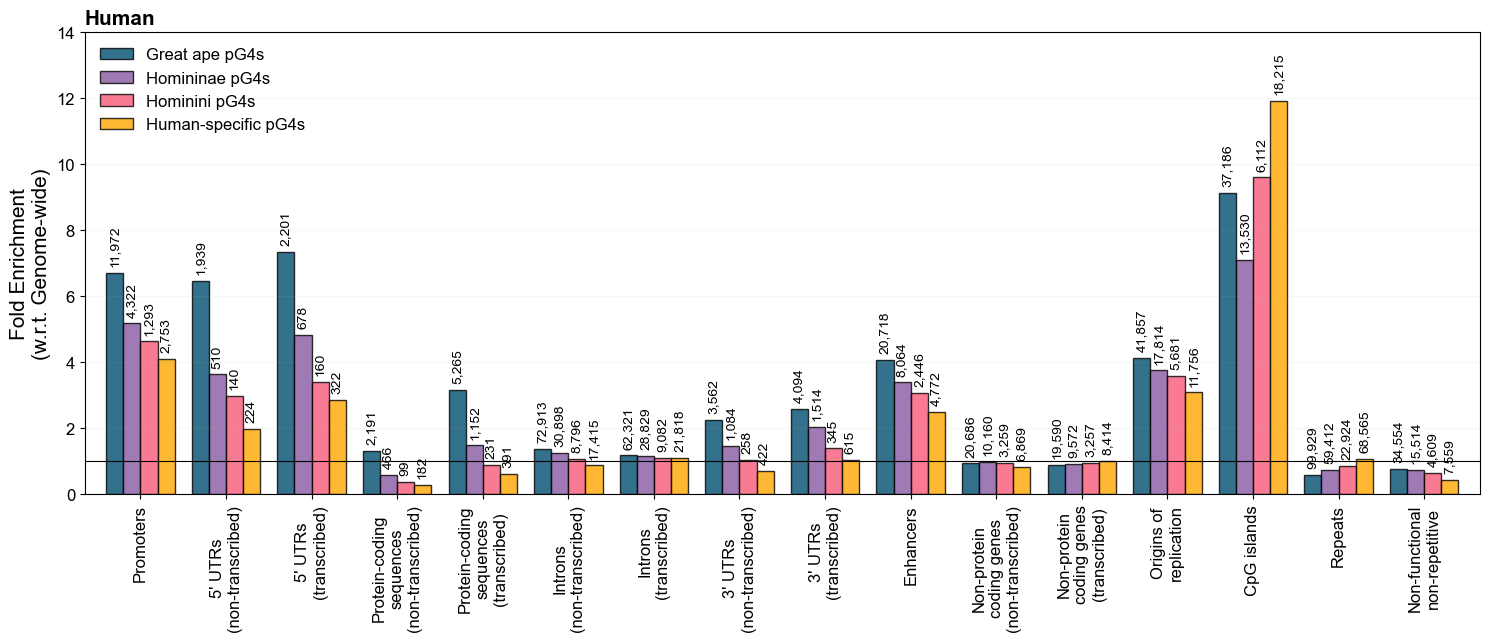

In [15]:
for name in species:
    # Load the datafile
    dist = pd.read_csv(f"../datasets/functionalOutputs/{scientificName[name]}/dist_mat.df", header=0, sep="\t", low_memory=False)
    distplot = dist.set_index("Region")
    distplot.rename(columns=distplot.columns.to_series().map(columnNamesReplaceFold).fillna(distplot.columns.to_series()).to_dict(), inplace=True)
    
    # Get the columns which have the enrichment information
    relevantCols = [i for i in distplot.columns if i.endswith(" pG4s")]

    # Plot the data
    barwidth = len(relevantCols) * 0.2
    ax = distplot.plot(kind="bar", y=relevantCols, figsize=(18,6), color=pd.Series(relevantCols).map(colormapper).to_list(), alpha=0.8, legend=False, width=barwidth, edgecolor='black')

    # Add the number of G4s to the plot
    g4snumCols = [col for col in distplot.columns if col.endswith("G4s#")]
    quant = distplot[g4snumCols]
    enrichment = distplot[relevantCols]
    eachbar = barwidth/len(relevantCols)
    for n, (idx, row) in enumerate(distplot.iterrows()):
        pos = 0
        for qt, en in zip(quant.columns, enrichment.columns):
            enrich = distplot.loc[idx, en]
            if enrich >= 0:
                ax.text(n + eachbar * (pos - (len(relevantCols)-1)/2), distplot.loc[idx, en] + 0.2, f"{distplot.loc[idx, qt]:,}", 
                        rotation=90, fontsize=10, ha="center", va="bottom")
            else:
                ax.text(n + eachbar * (pos - (len(relevantCols)-1)/2), distplot.loc[idx, en] - 0.2, f"{distplot.loc[idx, qt]:,}", 
                        rotation=90, fontsize=10, ha="center", va="top")
            pos += 1
    # print(enrichment)

    plt.ylabel("Fold Enrichment\n(w.r.t. Genome-wide)", fontsize=15)
    plt.ylim([0,14])
    plt.yticks(fontsize=12)

    plt.xlabel('')
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
               ["Promoters", "5' UTRs\n(non-transcribed)", "5' UTRs\n(transcribed)", "Protein-coding\nsequences\n(non-transcribed)", 
                "Protein-coding\nsequences\n(transcribed)", "Introns\n(non-transcribed)", "Introns\n(transcribed)", "3' UTRs\n(non-transcribed)", 
                "3' UTRs\n(transcribed)", "Enhancers", "Non-protein\ncoding genes\n(non-transcribed)", "Non-protein\ncoding genes\n(transcribed)", 
                "Origins of\nreplication", "CpG islands", "Repeats", "Non-functional\nnon-repetitive"], fontsize=12)
    
    plt.grid(axis='y', alpha=0.1)
    plt.legend(frameon=False, loc='best', fontsize=12)
    plt.hlines(1, -1.5, 16.5, lw=0.8, ls="-", alpha=1, color="#000")
    plt.title(f'{name.capitalize()}', loc='left', fontweight='black', fontsize=15)

    plt.savefig(f"../plots/enrichmentPlots/{scientificName[name]}/elements_foldEnrichmentAdj_barplot.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"../plots/enrichmentPlots/{scientificName[name]}/elements_foldEnrichmentAdj_barplot.svg", format='svg', transparent=True, bbox_inches="tight")

    plt.show()

##### pG4 enrichment GC-adjusted

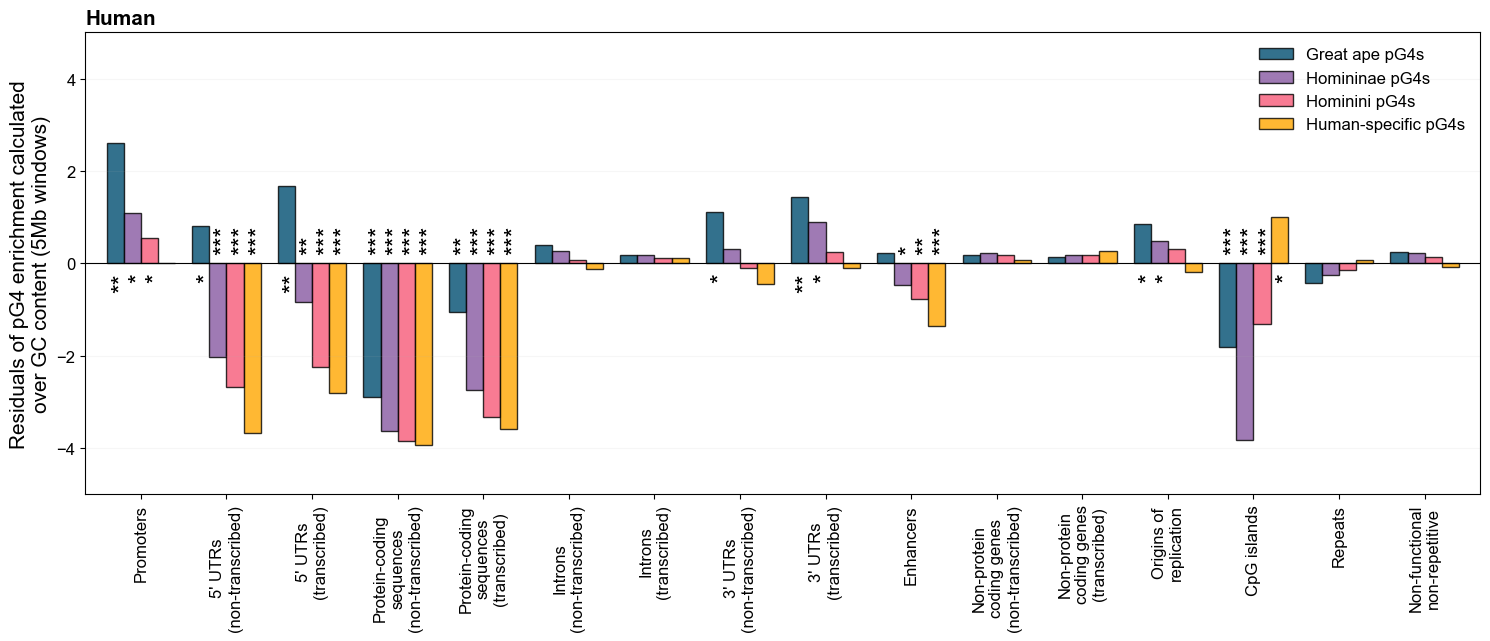

In [16]:
for name in species:
    # Load the datafile
    dist = pd.read_csv(f"../datasets/functionalOutputs/{scientificName[name]}/dist_mat.df", header=0, sep="\t", low_memory=False)
    distplot = dist.set_index("Region")
    distplot.rename(columns=distplot.columns.to_series().map(columnNamesReplaceFoldAdj).fillna(distplot.columns.to_series()).to_dict(), inplace=True)
    
    # Get the columns which have the enrichment information
    relevantCols = [i for i in distplot.columns if i.endswith(" pG4s")]

    # Plot the data
    barwidth = len(relevantCols) * 0.2
    ax = distplot.plot(kind="bar", y=relevantCols, figsize=(18,6), color=pd.Series(relevantCols).map(colormapper).to_list(), alpha=0.8, legend=False, width=barwidth, edgecolor='black')

    # Add the number of G4s to the plot
    g4snumCols = [col for col in distplot.columns if col.endswith("G4s#")]
    quant = distplot[g4snumCols]
    enrichment = distplot[relevantCols]
    eachbar = barwidth/len(relevantCols)
    alpha = 0.05
    residuals = quad_models[winSize].resid # Get the residuals from the model
    eachbar = barwidth/len(relevantCols)
    for n, (idx, row) in enumerate(distplot.iterrows()):
        pos = 0
        for qt, en in zip(quant.columns, enrichment.columns):
            enrich = distplot.loc[idx, en]
            percentile, p_value = calculate_significance(residuals, enrich)

            p_value = p_value * 2  # Two-tailed test

            if p_value < alpha:
                if np.sign(distplot.loc[idx, en]) == 1:
                    ax.text(n + eachbar * (pos - (len(relevantCols)-1)/2) + eachbar/2.5, np.sign(distplot.loc[idx, en])*(-0.2), f"{significance_stars(p_value)}", 
                        rotation=90, fontsize=18, ha="center",color='black', va="top", fontfamily='Arial')
                else:
                    ax.text(n + eachbar * (pos - (len(relevantCols)-1)/2) + eachbar/2.5, np.sign(distplot.loc[idx, en])*(-0.2), f"{significance_stars(p_value)}", 
                        rotation=90, fontsize=18, ha="center",color='black', va="bottom", fontfamily='Arial')
            pos += 1
    #print(enrichment)

    plt.ylabel("Residuals of pG4 enrichment calculated\nover GC content (5Mb windows)", fontsize=15)
    plt.ylim([-5,5])
    plt.yticks(fontsize=12)

    plt.xlabel('')
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
               ["Promoters", "5' UTRs\n(non-transcribed)", "5' UTRs\n(transcribed)", "Protein-coding\nsequences\n(non-transcribed)", 
                "Protein-coding\nsequences\n(transcribed)", "Introns\n(non-transcribed)", "Introns\n(transcribed)", "3' UTRs\n(non-transcribed)", 
                "3' UTRs\n(transcribed)", "Enhancers", "Non-protein\ncoding genes\n(non-transcribed)", "Non-protein\ncoding genes\n(transcribed)", 
                "Origins of\nreplication", "CpG islands", "Repeats", "Non-functional\nnon-repetitive"], fontsize=12)
    
    
    plt.grid(axis='y', alpha=0.1)
    plt.legend(frameon=False, loc='best', fontsize=12)
    plt.hlines(0, -1.5, 16.5, lw=0.8, ls="-", alpha=1, color="#000")
    plt.title(f'{name.capitalize()}', loc='left', fontweight='black', fontsize=15)

    plt.savefig(f"../plots/enrichmentPlots/{scientificName[name]}/elements_foldEnrichmentAdj_barplot_residual.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"../plots/enrichmentPlots/{scientificName[name]}/elements_foldEnrichmentAdj_barplot_residual.svg", format='svg', transparent=True, bbox_inches="tight")

    plt.show()

$$\text{Fold Enrichment}=\left(\frac{\frac{\text{Number of G4s in region X}}{\text{Total Number of G4s}}}{\frac{\text{Length of region X}}{\text{Chromosome Length}}}\right)$$

## 3. Plots for methylation and their significance in different functional categories

#### HG002 cell-line

In [17]:
bw_metric = 0.3

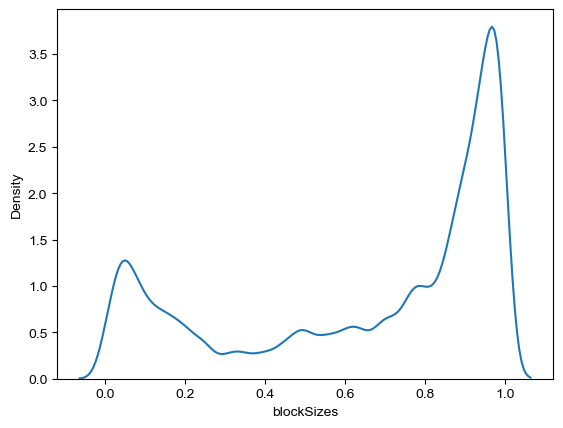

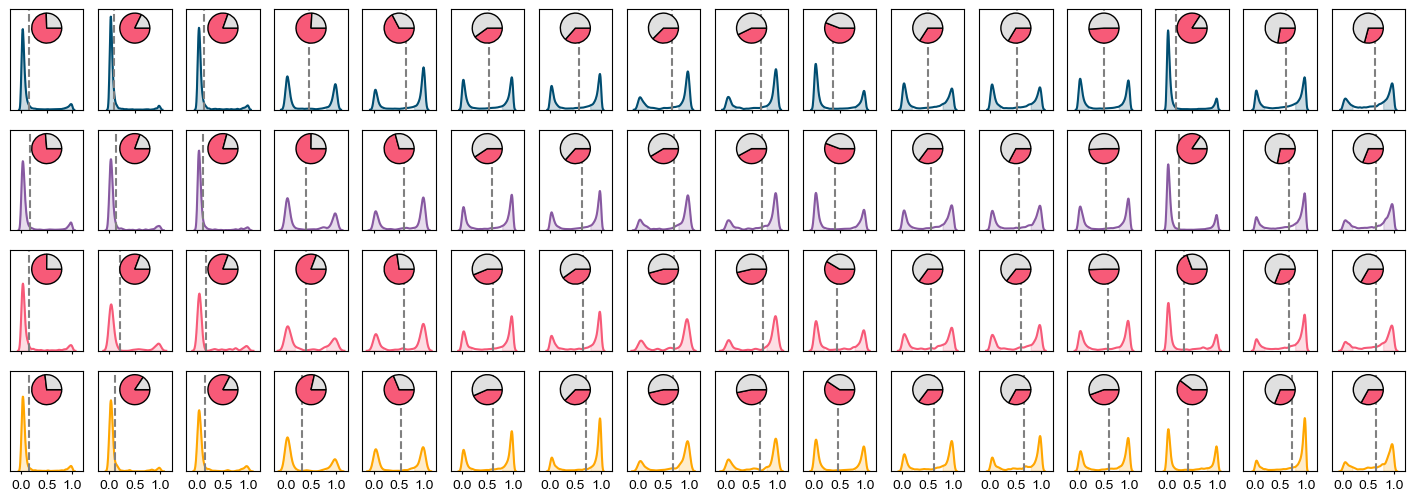

In [18]:
allSpeciesProportion = dict()
maxDens = dict()

for name in species:
    # Load the methylation datafile
    methylationData = BedTool(f"../datasets/dataForAnalysis/methylationData/{scientificName[name]}/chrG_chm13v2.0_hg002_CpG_5mC_methylation.bed.gz")
    dist = pd.read_csv(f"../datasets/functionalOutputs/{scientificName[name]}/dist_mat.df", header=0, sep="\t", low_memory=False)

    # Code block to calculate maximum density
    subplotCount = 0
    maxDen = 0
    annotatedWithMetDat_globDict = dict()
    for nos, group in enumerate(groupGQ[name]):
        annotatedWithMetDat_locDict = dict()
        for t in dist['Region']:
            subplotCount += 1
            annotated = pd.read_csv(f"../datasets/functionalOutputs/{scientificName[name]}/allhsaG.intersected.betn.{name}_{t}.{group}G4s.bed.gz",header=None,delimiter="\t",compression='gzip')
            annotated.drop(columns=[6,7,8,9,10,11,12], inplace=True)
            annotatedWithCpG = BedTool.from_dataframe(annotated).intersect(methylationData, wa=True, wb=True)
            annotatedWithCpG = annotatedWithCpG.to_dataframe()
            annotatedWithMetDat = annotatedWithCpG.groupby(["chrom","start","end","name","score","strand"],as_index=False)["blockSizes"].mean()
            # store the annotated and annotatedWithMetDat dataframes in a dictionary
            annotatedWithMetDat_locDict[t] = [annotated, annotatedWithMetDat]

            ax.clear()
            ax = sns.kdeplot(data=annotatedWithMetDat["blockSizes"], bw_adjust=bw_metric)
            curDensity = ax.get_ylim()[1]
            # Update the maximum density if the current density is greater
            if curDensity > maxDen:
                maxDen = curDensity

            print(f"Total = {len(groupGQ[name])*len(dist['Region'])}, Current = {subplotCount}", end="\r")
        annotatedWithMetDat_globDict[group] = annotatedWithMetDat_locDict
    maxDens[name] = maxDen

    ## Code block for actual plotting
    subplotCount = 0   
    order = groupGQ[name].copy()
    fig, axes = plt.subplots(len(order), len(dist['Region']), figsize=(len(dist['Region'])+2, len(order)+2), sharex=True, sharey=True)
    proportion_data = [] #store the hypomethylated proportion data

    for nos, group in enumerate(order):
        color = colormapper2[group]
        for idx, t in enumerate(dist['Region']):
            subplotCount += 1
            # load the dataframes from the dictionary
            annotated = annotatedWithMetDat_globDict[group][t][0]
            annotatedWithMetDat = annotatedWithMetDat_globDict[group][t][1]

            count = len(annotatedWithMetDat[annotatedWithMetDat["blockSizes"] < 0.2])
            nobs = len(annotatedWithMetDat)
            proportion_data.append([t, group, count, nobs])

            ax = sns.kdeplot(data=annotatedWithMetDat["blockSizes"], fill=False, bw_adjust=bw_metric, color=color, ax=axes[nos,idx]) #plot the kdeplot

            # Get the x and y values from the plot to manipulate the fill manually
            x_vals = ax.lines[0].get_xdata()
            y_vals = ax.lines[0].get_ydata()
            ax.fill_between(x_vals, y_vals, where=(x_vals >= 0.2) & (x_vals <= 0.8), color='white') # Fill the kdeplot between 0.2 and 0.8 with grey
            ax.fill_between(x_vals, y_vals, where=(x_vals < 0.2) | (x_vals > 0.8), color=color, alpha=0.2) # Fill the rest with the original color

            ax.set(xlabel='', ylabel='', yticks=[]) #set the labels and ticks
            ax.tick_params(axis='x', length=2)
            ax.set_xticks([0,0.5,1]) #set the x-axis ticks
            
            ax.set_ylim([0, np.ceil(maxDen)]) #when you don't know the max density
            ax.axvline(np.mean(annotatedWithMetDat["blockSizes"]), color='grey', linestyle='--')

            # Add a pie chart in the upper-right corner
            percentage = (len(annotatedWithMetDat) / len(annotated.iloc[:, [0, 1, 2, 5]].drop_duplicates())) * 100
            sizes = [percentage, 100 - percentage]
            colors = ['#f75a78', '#e0e0e0']  # Pie chart colors

            # Create the pie chart inset in the subplot
            radius = 0.25/len(order) #0.06
            xcenter = (ax.get_position().x1 + ax.get_position().x0)/2
            inset_ax = fig.add_axes([xcenter - radius/2, ax.get_position().y1 - radius, radius, radius], aspect='equal')
            inset_ax.pie(sizes, colors=colors, startangle=0, counterclock=False, wedgeprops={'edgecolor': 'black'})
            inset_ax.set_xticks([])
            inset_ax.set_yticks([])

            # print(f"Total = {len(order)*len(dist['Region'])}, Current = {subplotCount}", end="\r")

    proportion_df = pd.DataFrame(proportion_data, columns=["region", "type", "count", "n_obs"])
    allSpeciesProportion[name] = proportion_df

    plt.savefig(f"../plots/methylationPlots/{scientificName[name]}/methylation_density_plots.svg", format='svg', bbox_inches='tight', transparent=True)
    plt.savefig(f"../plots/methylationPlots/{scientificName[name]}/methylation_density_plots.png", dpi=300, bbox_inches='tight')

    plt.show()

##### To calculate the significance difference between hypomethylated proportions between groups

In [19]:
statPvals = [] 

# get the combinations of the groups
combs = list(combinations(range(len(order)), 2))
num_comparisons = len(combs)
alpha = 0.05

# Create the column names as a combination of the groups
comparison_columns = ['region']
for comb in combs:
    comparison_columns.append(f"{order[comb[0]].capitalize()} ({comb[0] + 1}) vs {order[comb[1]].capitalize()} ({comb[1] + 1})")
groupedProportion = proportion_df.groupby(["region"])

# Calculate the p-values for each region using the z-test
for region, group in groupedProportion:
    pvals = []
    for comb in combs:
        group1 = group[group['type'] == order[comb[0]]]
        group2 = group[group['type'] == order[comb[1]]]
        
        zstat, pval = proportion.proportions_ztest([int(group1["count"]), int(group2["count"])], [int(group1["n_obs"]), int(group2["n_obs"])], alternative='two-sided')

        #bonferroni correction
        pval = pval * num_comparisons
        pvals.append([round(zstat,2), round(pval,8)])

    statPvals.append([region[0]] + pvals)
    
statPvals = pd.DataFrame(statPvals, columns=comparison_columns).T
statPvals.columns = statPvals.iloc[0]
statPvals = statPvals.drop(statPvals.index[0])
statPvals = statPvals[['promoter', 'utr5', 'utr5.opp', 'cds', 'cds.opp', 'intron', 'intron.opp', 'utr3', 'utr3.opp', 'enhancer', 'npcgene', 'npcgene.opp', 'or', 'cpgi', 'repeats', 'ngnr']]
statPvals.index.name = 'Comparisons'
statPvals.columns = ["Promoters", "5' UTRs (-)", "5' UTRs (+)", "Protein-coding sequences (-)", 
                "Protein-coding sequences (+)", "Introns (-)", "Introns (+)", "3' UTRs (-)", 
                "3' UTRs (+)", "Enhancers", "Non-Protein coding genes (-)", "Non-Protein coding genes (+)", 
                "Origins of Replication", "CpG Islands", "Repeats", "NFNR"]
statPvals

,Promoters,5' UTRs (-),5' UTRs (+),Protein-coding sequences (-),Protein-coding sequences (+),Introns (-),Introns (+),3' UTRs (-),3' UTRs (+),Enhancers,Non-Protein coding genes (-),Non-Protein coding genes (+),Origins of Replication,CpG Islands,Repeats,NFNR
Comparisons,,,,,,,,,,,,,,,,
Hominid (1) vs Homininae (2),"[3.5, 0.00279249]","[2.74, 0.03722576]","[-1.2, 1.37642408]","[-1.88, 0.35807132]","[-2.24, 0.15081964]","[14.11, 0.0]","[11.48, 0.0]","[1.16, 1.46468109]","[1.47, 0.85277174]","[7.32, 0.0]","[7.36, 0.0]","[6.2, 0.0]","[10.01, 0.0]","[15.01, 0.0]","[15.63, 0.0]","[1.22, 1.34078211]"
Hominid (1) vs Hominini (3),"[0.91, 2.16654008]","[4.32, 9.525e-05]","[2.55, 0.06419087]","[-0.74, 2.74686992]","[-1.27, 1.21993951]","[11.65, 0.0]","[10.47, 0.0]","[0.62, 3.2143882]","[0.57, 3.39989161]","[8.33, 0.0]","[5.09, 2.17e-06]","[6.26, 0.0]","[9.44, 0.0]","[28.4, 0.0]","[12.45, 0.0]","[3.0, 0.01612589]"
Hominid (1) vs Humanspecific (4),"[-0.22, 4.96067832]","[0.34, 4.42478979]","[1.87, 0.36511986]","[-3.92, 0.00052368]","[-4.11, 0.00024233]","[13.38, 0.0]","[21.46, 0.0]","[0.81, 2.51465776]","[-0.65, 3.08856089]","[10.97, 0.0]","[10.43, 0.0]","[15.19, 0.0]","[17.02, 0.0]","[59.77, 0.0]","[28.75, 0.0]","[3.35, 0.00485779]"
Homininae (2) vs Hominini (3),"[-1.1, 1.63118571]","[2.07, 0.23044555]","[3.02, 0.01535343]","[0.21, 5.00652712]","[-0.15, 5.28967399]","[2.83, 0.02806091]","[2.89, 0.02304219]","[-0.04, 5.82230424]","[-0.24, 4.88299464]","[3.4, 0.00404649]","[0.38, 4.23833286]","[1.98, 0.28528181]","[2.94, 0.01981061]","[15.18, 0.0]","[1.13, 1.56136795]","[2.11, 0.20667915]"
Homininae (2) vs Humanspecific (4),"[-2.66, 0.04621815]","[-1.3, 1.15250696]","[2.44, 0.08699612]","[-2.37, 0.10637361]","[-2.36, 0.10954913]","[1.61, 0.64670385]","[10.16, 0.0]","[-0.02, 5.91379386]","[-1.57, 0.70517258]","[4.18, 0.00017214]","[3.74, 0.00108398]","[8.4, 0.0]","[8.0, 0.0]","[35.19, 0.0]","[10.89, 0.0]","[2.21, 0.16369873]"
Hominini (3) vs Humanspecific (4),"[-0.92, 2.13167489]","[-2.82, 0.02899281]","[-0.89, 2.23545137]","[-1.91, 0.33981209]","[-1.53, 0.75102625]","[-1.46, 0.86712606]","[4.83, 8.4e-06]","[0.02, 5.90562129]","[-0.89, 2.22513571]","[-0.08, 5.5957847]","[2.42, 0.09414659]","[4.41, 6.099e-05]","[3.3, 0.00581758]","[11.41, 0.0]","[7.14, 0.0]","[-0.24, 4.83983708]"


In [20]:
def significance_stars_withZstat(pval):
    if isinstance(pval, list):
        pval = np.abs(pval[1])
    if pd.isna(pval):  # For NaN values
        return ""
    elif pval <= 0.001:
        return "***"
    elif pval <= 0.01:
        return "**"
    elif pval <= 0.05:
        return "*"
    else:
        return ""

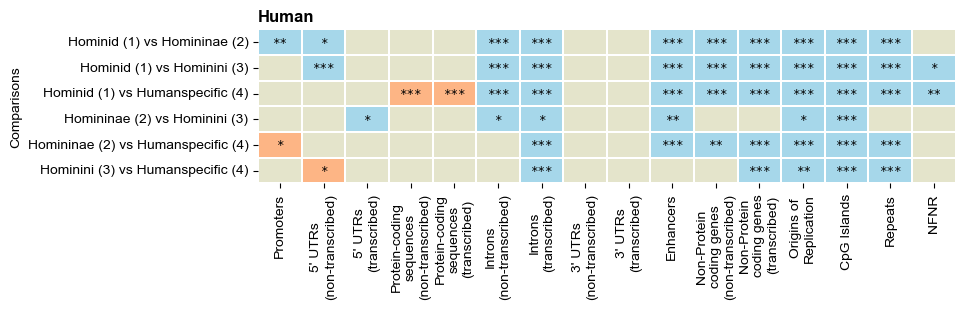

In [21]:
# Apply the function to add stars to each p-value
star_annotations = statPvals.applymap(significance_stars_withZstat)

colors = ['#fdb585', '#a6d7ea']
cmap = LinearSegmentedColormap.from_list('custom', colors)
cmap.set_bad('#e4e4cb')

# Separate the p-values and the signs for coloring
sig_p_vals = statPvals.applymap(lambda x: x[1] if x[1] < 0.05 else np.nan)
posNeg_mask = statPvals.applymap(lambda x: np.sign(x[0]) if x[1] < 0.05 else np.nan)

# Create the heatmap with the annotated p-values and stars
plt.figure(figsize=(9, (len(statPvals))/3))

sns.heatmap(data=posNeg_mask.astype(float), 
            annot=star_annotations, 
            fmt="", 
            annot_kws={'size': 9, 'fontfamily': 'monospace', 'color': 'black', 'va': 'center'}, 
            cmap=cmap, 
            cbar=False,  # No colorbar
            linecolor='#fff', 
            linewidth=0.01, 
            vmax=0.05/num_comparisons)

plt.xticks(np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])+0.5,["Promoters", "5' UTRs\n(non-transcribed)", "5' UTRs\n(transcribed)", "Protein-coding\nsequences\n(non-transcribed)", 
                "Protein-coding\nsequences\n(transcribed)", "Introns\n(non-transcribed)", "Introns\n(transcribed)", "3' UTRs\n(non-transcribed)", 
                "3' UTRs\n(transcribed)", "Enhancers", "Non-Protein\ncoding genes\n(non-transcribed)", "Non-Protein\ncoding genes\n(transcribed)", 
                "Origins of\nReplication", "CpG Islands", "Repeats", "NFNR"], fontsize=10, ha='center')
plt.title(f'Human', loc='left', fontweight='bold')

plt.savefig(f"../plots/methylationPlots/{scientificName[name]}/methylation_density_significance.png", dpi=300, bbox_inches='tight')

plt.show()

#### CHM13 cell-line

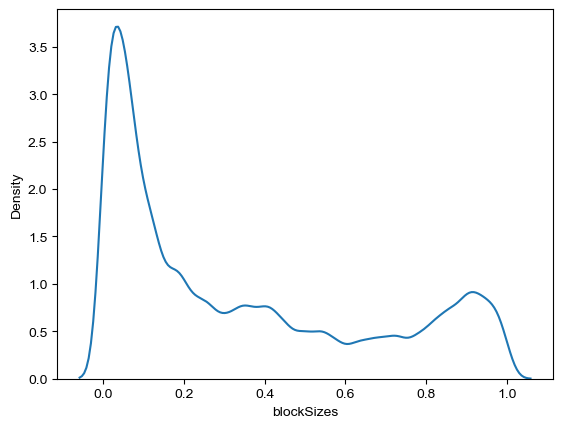

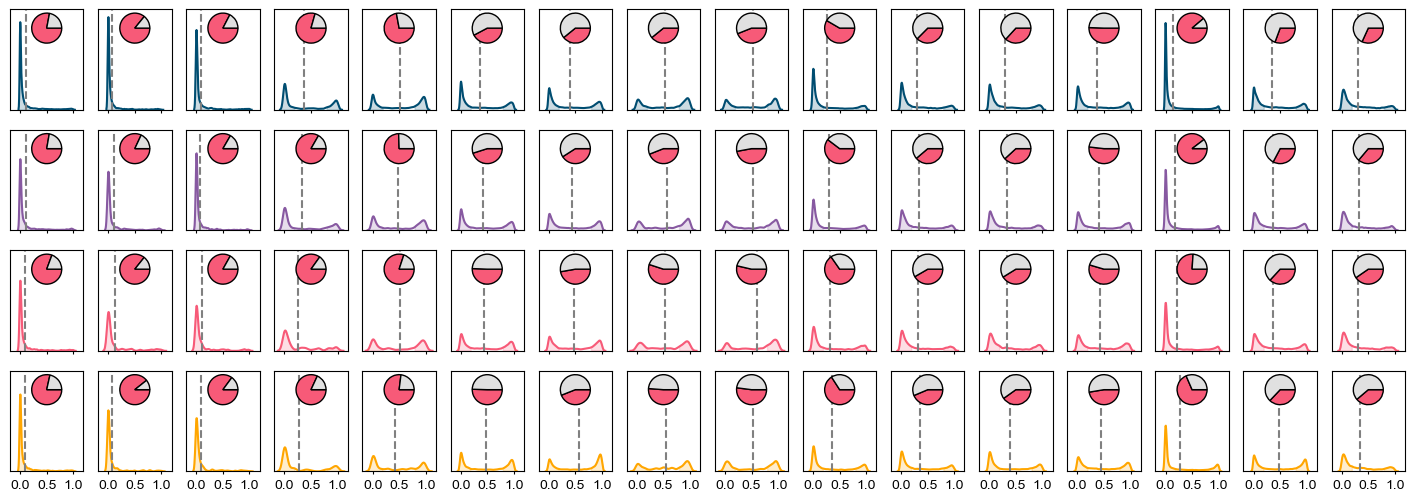

In [22]:
maxDens = dict()

for name in species:
    # Load the methylation datafile
    methylationData = BedTool(f"../datasets/dataForAnalysis/methylationData/{scientificName[name]}/chm13v2.0_CHM13_CpG_ont_guppy3.6.0_nanopolish0.13.2.bed.gz")
    dist = pd.read_csv(f"../datasets/functionalOutputs/{scientificName[name]}/dist_mat.df", header=0, sep="\t", low_memory=False)

    # Code block to calculate maximum density
    subplotCount = 0
    maxDen = 0
    annotatedWithMetDat_globDict = dict()
    for nos, group in enumerate(groupGQ[name]):
        annotatedWithMetDat_locDict = dict()
        for t in dist['Region']:
            subplotCount += 1
            annotated = pd.read_csv(f"../datasets/functionalOutputs/{scientificName[name]}/allhsaG.intersected.betn.{name}_{t}.{group}G4s.bed.gz",header=None,delimiter="\t",compression='gzip')
            annotated.drop(columns=[6,7,8,9,10,11,12], inplace=True)
            annotatedWithCpG = BedTool.from_dataframe(annotated).intersect(methylationData, wa=True, wb=True)
            annotatedWithCpG = annotatedWithCpG.to_dataframe()
            annotatedWithMetDat = annotatedWithCpG.groupby(["chrom","start","end","name","score","strand"],as_index=False)["blockSizes"].mean()
            # store the annotated and annotatedWithMetDat dataframes in a dictionary
            annotatedWithMetDat_locDict[t] = [annotated, annotatedWithMetDat]

            ax.clear()
            ax = sns.kdeplot(data=annotatedWithMetDat["blockSizes"], bw_adjust=bw_metric)
            curDensity = ax.get_ylim()[1]
            # Update the maximum density if the current density is greater
            if curDensity > maxDen:
                maxDen = curDensity

            print(f"Total = {len(groupGQ[name])*len(dist['Region'])}, Current = {subplotCount}", end="\r")
        annotatedWithMetDat_globDict[group] = annotatedWithMetDat_locDict
    maxDens[name] = maxDen

    ## Code block for actual plotting
    subplotCount = 0   
    order = groupGQ[name].copy()
    fig, axes = plt.subplots(len(order), len(dist['Region']), figsize=(len(dist['Region'])+2, len(order)+2), sharex=True, sharey=True)
    proportion_data_chm13 = [] #store the hypomethylated proportion data

    for nos, group in enumerate(order):
        color = colormapper2[group]
        for idx, t in enumerate(dist['Region']):
            subplotCount += 1
            #load the dataframes from the dictionary
            annotated = annotatedWithMetDat_globDict[group][t][0]
            annotatedWithMetDat = annotatedWithMetDat_globDict[group][t][1]

            count = len(annotatedWithMetDat[annotatedWithMetDat["blockSizes"] < 0.2])
            nobs = len(annotatedWithMetDat)
            proportion_data_chm13.append([t, group, count, nobs])

            ax = sns.kdeplot(data=annotatedWithMetDat["blockSizes"], fill=False, bw_adjust=bw_metric, color=color, ax=axes[nos,idx]) #plot the kdeplot

            # Get the x and y values from the plot to manipulate the fill manually
            x_vals = ax.lines[0].get_xdata()
            y_vals = ax.lines[0].get_ydata()
            ax.fill_between(x_vals, y_vals, where=(x_vals >= 0.2) & (x_vals <= 0.8), color='white') # Fill the kdeplot between 0.2 and 0.8 with grey
            ax.fill_between(x_vals, y_vals, where=(x_vals < 0.2) | (x_vals > 0.8), color=color, alpha=0.2) # Fill the rest with the original color

            ax.set(xlabel='', ylabel='', yticks=[]) #set the labels and ticks
            ax.tick_params(axis='x', length=2)  #set the x-axis label size and length
            ax.set_xticks([0,0.5,1]) #set the x-axis ticks
            
            ax.set_ylim([0, np.ceil(maxDen)]) #when you don't know the max density
            ax.axvline(np.mean(annotatedWithMetDat["blockSizes"]), color='grey', linestyle='--')

            # Add a pie chart in the upper-right corner
            percentage = (len(annotatedWithMetDat) / len(annotated.iloc[:, [0, 1, 2, 5]].drop_duplicates())) * 100
            sizes = [percentage, 100 - percentage]
            colors = ['#f75a78', '#e0e0e0']  # Pie chart colors

            # Create the pie chart inset in the subplot
            radius = 0.25/len(order)
            xcenter = (ax.get_position().x1 + ax.get_position().x0)/2
            inset_ax = fig.add_axes([xcenter - radius/2, ax.get_position().y1 - radius, radius, radius], aspect='equal')
            inset_ax.pie(sizes, colors=colors, startangle=0, counterclock=False, wedgeprops={'edgecolor': 'black'})
            inset_ax.set_xticks([])
            inset_ax.set_yticks([])

            # print(f"Total = {len(order)*len(dist['Region'])}, Current = {subplotCount}", end="\r")

    proportion_df_chm13 = pd.DataFrame(proportion_data_chm13, columns=["region", "type", "count", "n_obs"])

    plt.savefig(f"../plots/methylationPlots/{scientificName[name]}/methylation_density_plots_CHM13.svg", format='svg', bbox_inches='tight', transparent=True)
    plt.savefig(f"../plots/methylationPlots/{scientificName[name]}/methylation_density_plots_CHM13.png", dpi=300, bbox_inches='tight')

    plt.show()

##### To calculate the significance difference between hypomethylated proportions between groups

In [23]:
statPvals = [] 

# get the combinations of the groups
combs = list(combinations(range(len(order)), 2))
num_comparisons = len(combs)
alpha = 0.05

# Create the column names as a combination of the groups
comparison_columns = ['region']
for comb in combs:
    comparison_columns.append(f"{order[comb[0]].capitalize()} ({comb[0] + 1}) vs {order[comb[1]].capitalize()} ({comb[1] + 1})")
groupedProportion = proportion_df_chm13.groupby(["region"])

# Calculate the p-values for each region using the z-test
for region, group in groupedProportion:
    pvals = []
    for comb in combs:
        group1 = group[group['type'] == order[comb[0]]]
        group2 = group[group['type'] == order[comb[1]]]
        
        zstat, pval = proportion.proportions_ztest([int(group1["count"]), int(group2["count"])], [int(group1["n_obs"]), int(group2["n_obs"])], alternative='two-sided')

        #bonferroni correction
        pval = pval * num_comparisons
        pvals.append([round(zstat,2), round(pval,8)])

    statPvals.append([region[0]] + pvals)
    
statPvals = pd.DataFrame(statPvals, columns=comparison_columns).T
statPvals.columns = statPvals.iloc[0]
statPvals = statPvals.drop(statPvals.index[0])
statPvals = statPvals[['promoter', 'utr5', 'utr5.opp', 'cds', 'cds.opp', 'intron', 'intron.opp', 'utr3', 'utr3.opp', 'enhancer', 'npcgene', 'npcgene.opp', 'or', 'cpgi', 'repeats', 'ngnr']]
statPvals.index.name = 'Comparisons'
statPvals.columns = ["Promoters", "5' UTRs (-)", "5' UTRs (+)", "Protein-coding sequences (-)", 
                "Protein-coding sequences (+)", "Introns (-)", "Introns (+)", "3' UTRs (-)", 
                "3' UTRs (+)", "Enhancers", "Non-Protein coding genes (-)", "Non-Protein coding genes (+)", 
                "Origins of Replication", "CpG Islands", "Repeats", "NFNR"]
statPvals

,Promoters,5' UTRs (-),5' UTRs (+),Protein-coding sequences (-),Protein-coding sequences (+),Introns (-),Introns (+),3' UTRs (-),3' UTRs (+),Enhancers,Non-Protein coding genes (-),Non-Protein coding genes (+),Origins of Replication,CpG Islands,Repeats,NFNR
Comparisons,,,,,,,,,,,,,,,,
Hominid (1) vs Homininae (2),"[2.15, 0.18971253]","[2.74, 0.03662244]","[-1.44, 0.90377561]","[-1.12, 1.57378758]","[-2.54, 0.06735462]","[11.62, 0.0]","[7.8, 0.0]","[1.62, 0.62813712]","[-0.1, 5.50042465]","[7.13, 0.0]","[6.1, 1e-08]","[6.28, 0.0]","[7.05, 0.0]","[13.44, 0.0]","[7.58, 0.0]","[0.44, 3.96512802]"
Hominid (1) vs Hominini (3),"[-1.55, 0.73190321]","[3.57, 0.00213224]","[0.91, 2.16376263]","[-1.45, 0.87931769]","[-0.59, 3.34833783]","[11.06, 0.0]","[9.85, 0.0]","[0.05, 5.74290897]","[1.52, 0.77372635]","[6.5, 0.0]","[1.86, 0.37309402]","[3.37, 0.00457768]","[6.4, 0.0]","[13.83, 0.0]","[4.76, 1.163e-05]","[-0.0, 5.9851449]"
Hominid (1) vs Humanspecific (4),"[-1.25, 1.27243396]","[0.17, 5.18192989]","[0.04, 5.803413]","[-3.29, 0.00607357]","[-3.18, 0.0088834]","[17.64, 0.0]","[26.28, 0.0]","[1.29, 1.17889369]","[-1.7, 0.53066892]","[12.77, 0.0]","[8.95, 0.0]","[10.13, 0.0]","[13.74, 0.0]","[40.07, 0.0]","[31.46, 0.0]","[4.25, 0.00012788]"
Homininae (2) vs Hominini (3),"[-2.6, 0.05660837]","[1.5, 0.80034575]","[1.64, 0.60712051]","[-0.83, 2.43148467]","[0.63, 3.17571329]","[3.44, 0.00353818]","[4.29, 0.00010489]","[-0.87, 2.31075962]","[1.48, 0.82783857]","[1.74, 0.4899133]","[-2.04, 0.2472899]","[-0.87, 2.31546785]","[1.71, 0.52634207]","[3.88, 0.0006335]","[-0.84, 2.3938861]","[-0.27, 4.71391237]"
Homininae (2) vs Humanspecific (4),"[-2.62, 0.05260774]","[-1.46, 0.85768]","[1.01, 1.8647776]","[-2.29, 0.13121232]","[-1.37, 1.02344628]","[7.02, 0.0]","[17.02, 0.0]","[0.11, 5.47353514]","[-1.46, 0.87187908]","[5.77, 5e-08]","[3.01, 0.01573077]","[3.5, 0.00277667]","[7.08, 0.0]","[20.73, 0.0]","[20.87, 0.0]","[3.56, 0.00224364]"
Hominini (3) vs Humanspecific (4),"[0.57, 3.41959398]","[-2.48, 0.07900805]","[-0.73, 2.78027945]","[-0.91, 2.18428705]","[-1.52, 0.77058674]","[1.99, 0.28122912]","[8.72, 0.0]","[0.85, 2.3794512]","[-2.37, 0.10768549]","[2.66, 0.04694771]","[4.19, 0.00016872]","[3.45, 0.00338992]","[3.8, 0.0008732]","[11.39, 0.0]","[16.83, 0.0]","[2.98, 0.01733544]"


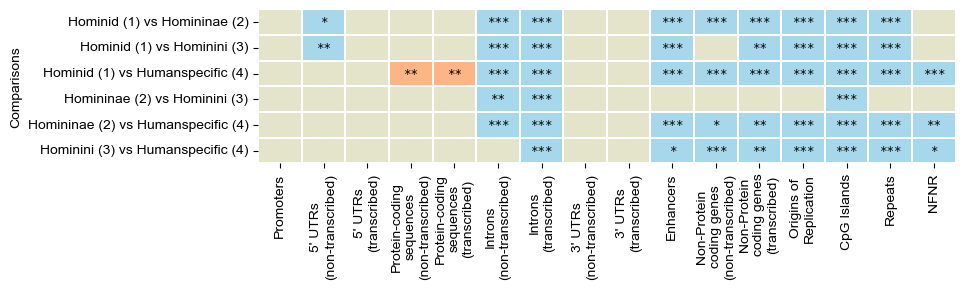

In [24]:
# Apply the function to add stars to each p-value
star_annotations = statPvals.applymap(significance_stars_withZstat)

colors = ['#fdb585', '#a6d7ea']
cmap = LinearSegmentedColormap.from_list('custom', colors)
cmap.set_bad('#e4e4cb')

# Separate the p-values and the signs for coloring
sig_p_vals = statPvals.applymap(lambda x: x[1] if x[1] < 0.05 else np.nan)
posNeg_mask = statPvals.applymap(lambda x: np.sign(x[0]) if x[1] < 0.05 else np.nan)

# Create the heatmap with the annotated p-values and stars
plt.figure(figsize=(9, (len(statPvals))/3))

sns.heatmap(data=posNeg_mask.astype(float), 
            annot=star_annotations, 
            fmt="", 
            annot_kws={'size': 9, 'fontfamily': 'monospace', 'color': 'black', 'va': 'center'}, 
            cmap=cmap, 
            cbar=False,  # No colorbar
            linecolor='#fff', 
            linewidth=0.01, 
            vmax=0.05/num_comparisons)

plt.xticks(np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])+0.5,["Promoters", "5' UTRs\n(non-transcribed)", "5' UTRs\n(transcribed)", "Protein-coding\nsequences\n(non-transcribed)", 
                "Protein-coding\nsequences\n(transcribed)", "Introns\n(non-transcribed)", "Introns\n(transcribed)", "3' UTRs\n(non-transcribed)", 
                "3' UTRs\n(transcribed)", "Enhancers", "Non-Protein\ncoding genes\n(non-transcribed)", "Non-Protein\ncoding genes\n(transcribed)", 
                "Origins of\nReplication", "CpG Islands", "Repeats", "NFNR"], fontsize=10, ha='center')

plt.savefig(f"../plots/methylationPlots/{scientificName[name]}/methylation_density_significance_CHM13.png", dpi=300, bbox_inches='tight')

plt.show()

#### To calculate the signifcant between hypomethylated proportion betn HG002 and CHM13 ( only in Hominid)

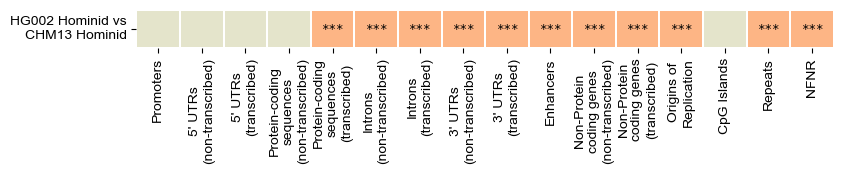

In [25]:
# only get the hominid data from the proportion dataframes of hg002 and chm13
proportion_df_hominid = proportion_df[proportion_df["type"]=="hominid"].copy()
proportion_df_chm13_hominid = proportion_df_chm13[proportion_df_chm13["type"]=="hominid"].copy()

# Calculate the z-test for the hominid data between hg002 and chm13 and store the results
betweenCellVals = []
for region in proportion_df_hominid["region"]:
    hg002 = proportion_df_hominid[proportion_df_hominid["region"]==region]
    chm13 = proportion_df_chm13_hominid[proportion_df_chm13_hominid["region"]==region]

    zstat, pval = proportion.proportions_ztest([int(hg002["count"]), int(chm13["count"])], [int(hg002["n_obs"]), int(chm13["n_obs"])], alternative='two-sided')
    betweenCellVals.append([region, zstat, round(pval,5), significance_stars(pval)])

betweenCellVals = pd.DataFrame(betweenCellVals, columns=["Region", "z-stat", "p-value", "sigLevel"])
betweenCellVals.loc[betweenCellVals['p-value'] < 0.05, 'sign_mask'] = np.sign(betweenCellVals['z-stat'])

# Plot the heatmap
plt.figure(figsize=(9,0.5))

sns.heatmap(data=betweenCellVals['sign_mask'].astype(float).values.reshape(1,-1), 
            annot=betweenCellVals['sigLevel'].values.reshape(1,-1), 
            fmt="", 
            annot_kws={'size': 9, 'fontfamily': 'monospace', 'color': 'black', 'va': 'center'}, 
            cmap=cmap, 
            cbar=False,  # No colorbar
            linecolor='#fff', 
            linewidth=0.01, 
            vmax=0.05/num_comparisons)

plt.xticks(np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])+0.5,["Promoters", "5' UTRs\n(non-transcribed)", "5' UTRs\n(transcribed)", "Protein-coding\nsequences\n(non-transcribed)", 
                "Protein-coding\nsequences\n(transcribed)", "Introns\n(non-transcribed)", "Introns\n(transcribed)", "3' UTRs\n(non-transcribed)", 
                "3' UTRs\n(transcribed)", "Enhancers", "Non-Protein\ncoding genes\n(non-transcribed)", "Non-Protein\ncoding genes\n(transcribed)", 
                "Origins of\nReplication", "CpG Islands", "Repeats", "NFNR"], fontsize=10, ha='center', rotation=90)

plt.yticks([0.5],["HG002 Hominid vs\nCHM13 Hominid"], fontsize=10, rotation=0)

plt.savefig(f"../plots/methylationPlots/{scientificName[name]}/methylation_density_significance_hominid_HG002vsCHM13.png", dpi=300, bbox_inches='tight')

plt.show()